In [1]:
import pandas as pd
import numpy as np
import psycopg2
import configparser
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge, Lasso
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import itertools
import configparser

In [2]:
# Import config data
config = configparser.ConfigParser()
config.read('app_client_extra.ini')
db_params = config['DB']
app_params = config['APP']

In [3]:
#load data from SQL
con = psycopg2.connect(host=db_params['host'], database=db_params['db'], user = db_params['user'], password = db_params['password'] )
sql = "SELECT * from %s" % (db_params['table'])
client_df = pd.read_sql_query(sql, con)

In [4]:
# To navigate through column
sorted(list(client_df.columns))

['actual_worked_hours',
 'additional_hours_p_t',
 'age',
 'all_included_premium',
 'all_other_included_items',
 'annualised_salaries_fte',
 'childcare',
 'deputising_allowance',
 'disability',
 'doi_flexi',
 'driver_flexi',
 'employee',
 'ethnic_origin',
 'ethnicity',
 'flexi_allowance',
 'flexi_comms_off',
 'flexibility_allowance',
 'ft_pt',
 'full_time_equivalent',
 'gender',
 'hourly_pay',
 'length_of_service',
 'location_allowance',
 'main_band_range',
 'market_allowance',
 'monthly_pay_basic',
 'overtime',
 'pay_point',
 'rank_band',
 'salary_annual_35_ft',
 'salary_per_month',
 'salary_per_week',
 'sat_prem_x_5',
 'service_related_pay',
 'service_start_date',
 'shift_disturbance_allowance',
 'skill_supplement',
 'sun_premium',
 'total_allowances',
 'typing_proficiency',
 'z1_allowance',
 'z2_allowance']

In [5]:
# Remove rows having unbanded salary
# client_df.drop(client_df.loc[client_df['main_band_range'] == 'Unbanded'].index, inplace=True)

In [6]:
client_df[client_df['annualised_salaries_fte'] > 80000]

,employee,main_band_range,rank_band,pay_point,monthly_pay_basic,gender,disability,age,actual_worked_hours,full_time_equivalent,...,location_allowance,all_included_premium,all_other_included_items,flexibility_allowance,annualised_salaries_fte,total_allowances,hourly_pay,salary_per_week,salary_per_month,salary_annual_35_ft
1,2,BB3,Broadband 3,0.0,8142.75,Male,unknown,50.0,36.0,1.00,...,0.00,0.0,0.00,0.0,97713.00,0.00,56.55,1979.14,8576.28,102915.31
20,21,Band A,Band S,5.0,6802.92,Female,No,58.0,36.0,1.00,...,218.58,0.0,0.00,0.0,84258.00,437.16,47.24,1653.49,7165.11,85981.35
30,31,Band A,Band H,6.0,6438.61,Female,unknown,52.0,31.5,0.88,...,191.26,0.0,0.00,0.0,92164.94,473.01,51.10,1788.50,7750.18,93002.14
39,40,Band A,Band S,3.0,6396.67,Female,No,54.0,36.0,1.00,...,218.58,0.0,406.25,0.0,85649.04,959.33,44.42,1554.75,6737.23,80846.80
70,70,Band A,Band S,5.0,6802.92,Male,unknown,48.0,36.0,1.00,...,218.58,0.0,0.00,0.0,85649.04,553.08,47.24,1653.49,7165.11,85981.35
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8032,8030,Band A,Band A,5.0,6030.75,Female,No,49.0,36.0,1.00,...,218.58,0.0,416.67,0.0,81171.00,952.08,41.88,1465.81,6351.83,76221.98
8093,8093,Band A,Band A,6.0,6289.92,Female,No,44.0,36.0,1.00,...,218.58,0.0,685.08,0.0,86322.96,1122.24,43.68,1528.80,6624.80,79497.60
8113,8113,Band A,Band S,4.0,6587.83,Male,No,47.0,36.0,1.00,...,218.58,0.0,0.00,0.0,81676.92,437.16,45.75,1601.21,6938.57,83262.85
8114,8114,BB2,Broadband 2,0.0,9935.58,Male,No,61.0,36.0,1.00,...,0.00,0.0,416.67,0.0,123641.04,416.67,69.00,2414.90,10464.56,125574.69


In [7]:
'''
Avg diff between annualised_salaries_fte (Gapsquare calc of annual FTE) 
and salary_annual_35_ft (Our calc of annual FTE) 
''' 
(client_df['annualised_salaries_fte'] - client_df['salary_annual_35_ft']).mean()

4502.750947559156

In [8]:
(client_df['annualised_salaries_fte']).sum()

361385968.63

In [9]:
(client_df['salary_annual_35_ft']).sum()

319141159.24

In [10]:
'''
1. Create annual FTE if not exist
2. Store annual FTE to columns '_annual_salary_fte' and '_total_annual_pkg'
'''
if ('weekly_hours_column' in app_params):
    client_df['_annual_salary_fte'] = client_df[app_params['actual_salary_column']] * (int(app_params['fte_hours']) / client_df[app_params['weekly_hours_column']])
else:
    client_df['_annual_salary_fte'] = client_df[app_params['actual_salary_column']]

client_df['_total_annual_pkg'] = client_df[app_params['actual_salary_column']]



In [11]:
'''
1. Consider all columns related to allowances/benefits
2. Convert to float (if required), add to existing _total_annual_pkg columns
'''

if ('benefits_column_list' in app_params):
    benefit_columns = app_params['benefits_column_list'].split(',')
    benefit_columns = [s.strip() for s in benefit_columns]
    for benefit_column in benefit_columns:
            try:
                client_df[benefit_column].apply(float)
                client_df['_total_annual_pkg'] += client_df[benefit_column]
            except:
                print('Float conversion failed')

In [12]:
'''
Calculate total annual package for FTE
'''
if ('weekly_hours_column' in app_params):
    client_df['_total_annual_pkg_fte'] = client_df['_total_annual_pkg'] * (int(app_params['fte_hours']) / client_df[app_params['weekly_hours_column']])
else: 
    client_df['_total_annual_pkg_fte'] = client_df['_total_annual_pkg']

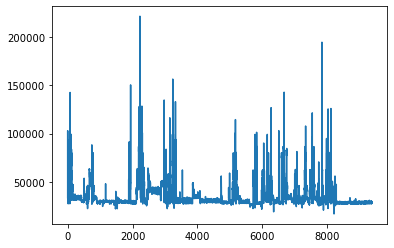

In [13]:
# Check distribution
plt.plot(client_df['_total_annual_pkg_fte'] )

In [14]:
'''
treat outliers and scale total package if needed
'''
if ('outlier_percentiles' in app_params):
    values = [s.strip() for s in app_params['outlier_percentiles'].split(',')]
    low, high = client_df['_total_annual_pkg_fte'].quantile( [float(values[0]), float(values[1])] )
    client_df = client_df.query("_total_annual_pkg_fte >= {} & _total_annual_pkg_fte <= {}".format(low, high))
    #reset index, make it linear again for ease of joining below
    client_df = client_df.reset_index()

In [15]:
'''
note this scales directly on the original dataframe, use only for feature selection.
set to false when predicting.
'''
scaler = MinMaxScaler(feature_range=(0, 1))
# if ('scale_target' in app_params and app_params['scale_target'].lower() == 'true'):
#     client_df['_total_annual_pkg_fte'] = scaler.fit_transform(client_df['_total_annual_pkg_fte'].values.reshape(-1, 1))

In [16]:
'''
One hot encoded features
'''
df_oh_cat_features = df_label_cat_features = df_num_features = None

if ('oh_cat_feature_list' in app_params):
    oh_cat_features = app_params['oh_cat_feature_list'].split(',')
    oh_cat_features = [s.strip() for s in oh_cat_features]
    df_oh_cat_features = pd.get_dummies(data=client_df[oh_cat_features], drop_first=True)
    if ('scale_cat_features' in app_params and app_params['scale_cat_features'].lower() == 'true'):
        for column in df_oh_cat_features.columns:
            df_oh_cat_features[column] = scaler.fit_transform(df_oh_cat_features[column].values.reshape(-1, 1)) 
            
            

In [17]:
'''
Label encoded features
'''
if ('label_cat_feature_list' in app_params):
    label_cat_features = app_params['label_cat_feature_list'].split(',')
    label_cat_features = [s.strip() for s in label_cat_features]
    le = LabelEncoder()
    for feature in label_cat_features:
        if (type(df_label_cat_features) != pd.DataFrame):
            df_label_cat_features = pd.DataFrame()
        le.fit(client_df[feature])
        df_label_cat_features[feature] = le.transform(client_df[feature])
        if ('scale_label_features' in app_params and app_params['scale_label_features'].lower() == 'true'):
             df_label_cat_features[feature] = scaler.fit_transform(df_label_cat_features[feature].values.reshape(-1, 1)) 

In [18]:
'''
Numerical features
'''
if ('num_feature_list' in app_params):
    num_features = app_params['num_feature_list'].split(',')
    num_features = [s.strip() for s in num_features]
    df_num_features = client_df[num_features]
    if ('scale_num_features' in app_params and app_params['scale_num_features'].lower() == 'true'):
        for feature in num_features:
            df_num_features[feature] = scaler.fit_transform(df_num_features[feature].values.reshape(-1, 1))

<ipython-input-18-38481d6adf0e>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_num_features[feature] = scaler.fit_transform(df_num_features[feature].values.reshape(-1, 1))
<ipython-input-18-38481d6adf0e>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_num_features[feature] = scaler.fit_transform(df_num_features[feature].values.reshape(-1, 1))
<ipython-input-18-38481d6adf0e>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,c

In [19]:
'''
Create X from our three feature dataframes if they have been initialised
'''
X = pd.DataFrame()
for features in (df_oh_cat_features, df_num_features, df_label_cat_features): #
    if type(features) == pd.DataFrame:
        if (X.empty):
            X = features
        else:    
            X = X.join(features)
            

In [20]:
'''
1. Create variable splits
2. Using the splits, create training and testing set
'''
drop = False
if ('train_split_column' in app_params):
    if (app_params['train_split_column'] not in X):
        drop = True
        X[app_params['train_split_column']] = client_df[app_params['train_split_column']]
    X = X.query("{} == '{}'".format(app_params['train_split_column'], app_params['train_split_value']))
    y = client_df.query("{} == '{}'".format(app_params['train_split_column'], app_params['train_split_value']))['_total_annual_pkg_fte']
    if drop:
        X.drop(app_params['train_split_column'], axis = 1, inplace=True )
else:
    y = client_df['_total_annual_pkg_fte']
    
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)    

In [21]:
X_train.shape

(6371, 8)

In [22]:
X_test.shape

(2124, 8)

Lasso train/test scores for alpha=1 0.77/0.77
Coefs used=8.00
Lasso train/test scores for alpha=0.1 0.77/0.77
Coefs used=8.00
Lasso train/test scores for alpha=0.01 0.77/0.77
Coefs used=8.00
Lasso train/test scores for alpha=0.0001 0.77/0.77
Coefs used=8.00


<function matplotlib.pyplot.show(close=None, block=None)>

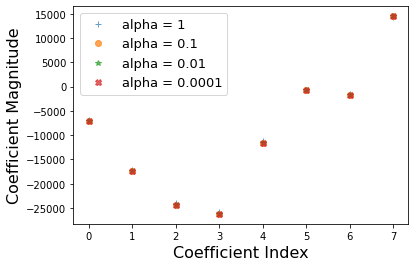

In [23]:
'''
LASSO
'''
markers = itertools.cycle(('+', 'o', '*', 'X', 'd')) 
alphas = [1, 0.1, 0.01, 0.0001]

for alpha in alphas:  
    lasso = Lasso(alpha=alpha, max_iter=10e5)
    lasso.fit(X_train,y_train)
    train_score=lasso.score(X_train,y_train)
    test_score=lasso.score(X_test,y_test)
    coeff_used = np.sum(lasso.coef_!=0)
    print("Lasso train/test scores for alpha={} {:.2f}/{:.2f}".format(alpha, train_score, test_score))
    print("Coefs used={:.2f}".format(coeff_used))
    plt.plot(lasso.coef_, marker=next(markers), alpha = 0.7, linestyle='none',label=r'alpha = {}'.format(alpha))
plt.xlabel('Coefficient Index',fontsize=16)
plt.ylabel('Coefficient Magnitude',fontsize=16)
plt.legend(fontsize=13,loc=2)
plt.show

Ridge train/test scores for alpha=0.01 0.77/0.77
Ridge train/test scores for alpha=1.00 0.77/0.77
Ridge train/test scores for alpha=10.00 0.76/0.77
Ridge train/test scores for alpha=100.00 0.68/0.71


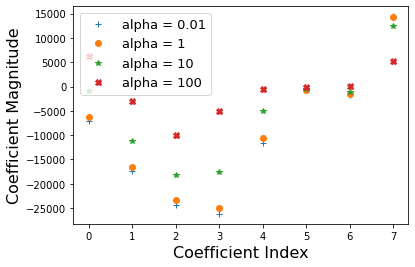

In [24]:
'''
RIDGE
'''
markers = itertools.cycle(('+', 'o', '*', 'X', 'd')) 
alphas = [0.01, 1, 10, 100]

for alpha in alphas:    
    ridge = Ridge(alpha=alpha)
    ridge.fit(X_train, y_train)
    train_score = ridge.score(X_train,y_train)
    test_score = ridge.score(X_test, y_test)
    print("Ridge train/test scores for alpha={:.2f} {:.2f}/{:.2f}".format(alpha, train_score, test_score))
    plt.plot(ridge.coef_, marker=next(markers), linestyle='none',label=r'alpha = {}'.format(alpha))

plt.xlabel('Coefficient Index',fontsize=16)
plt.ylabel('Coefficient Magnitude',fontsize=16)
plt.legend(fontsize=13,loc=2)
plt.show()

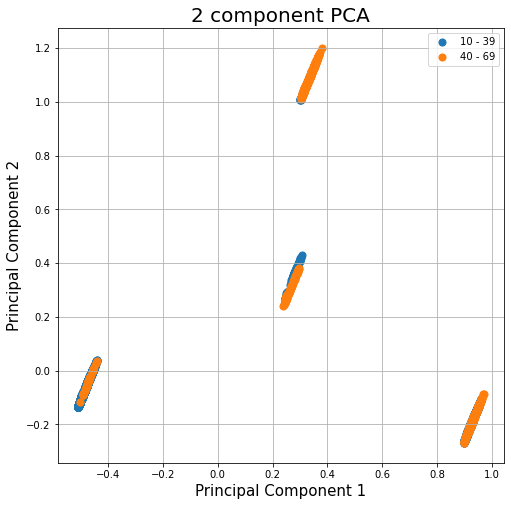

In [25]:

''' PCA - total annual package fte '''

#create some targets
target_ranges = [(10,39), (40,69), (70,99), (100,129), (130,159), (160,189), (190,219), (220,9999)]
targets = set() 
def get_pkg_range(package):
    thou = (int((package)/10000))*10
    for target_range in target_ranges:
        if (thou >= target_range[0] and thou <= target_range[1]):
            range = str(target_range[0]) + " - " + str(target_range[1])
            targets.add(range)
            return (range)

client_df['_total_annual_pkg_fte_range'] = client_df['_total_annual_pkg_fte'].apply(get_pkg_range)

n = 2 

pca = PCA(n_components=n)

columns=[]
for column_no in range(1,n+1):
    columns.append('PC {}'.format(column_no))

pc = pca.fit_transform(X)

#merge the targets back in
final_df = pd.DataFrame(data = pc, columns = columns)

final_df = pd.concat([final_df, client_df[['_total_annual_pkg_fte_range']]], axis = 1)

fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
#colors = ['r', 'g', 'b']
for target in targets:
    indicesToKeep = final_df['_total_annual_pkg_fte_range'] == target
    ax.scatter(final_df.loc[indicesToKeep, 'PC 1']
               , final_df.loc[indicesToKeep, 'PC 2']        
               , s = 50)
ax.legend(targets)
ax.grid()

# %%

